In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from corner import corner
from acor import acor

from matplotlib.colors import LogNorm
from enterprise import constants as const

%matplotlib inline

In [2]:
RN_dat = [
    ['J0030+0451', 0.025, 4.0],
    ['J0613-0200', 0.212, 1.2],
    ['J1012+5307', 0.476, 1.5],
    ['J1643-1224', 1.619, 1.3],
    ['J1713+0747', 0.021, 1.6],
    ['J1747-4036', 1.823, 1.4],
    ['B1855+09', 0.069, 3.0],
    ['J1903+0327', 1.615, 2.1],
    ['J1909-3744', 0.042, 1.7],
    ['B1937+21', 0.157, 2.8],
    ['J2145-0750', 0.589, 1.3],
]

# convert Ared from 11yr timing paper to Agwb units
red2gwb = np.sqrt(12)*np.pi * 1.0e-06/const.yr

timing_RN = {}
for psr, Ared, gam in RN_dat:
    logA = np.log10(Ared * red2gwb)
    timing_RN[psr+'_log10_A'] = logA
    timing_RN[psr+'_gamma'] = gam

In [98]:
snglT = False
idx = 5

truncT = True
#start = 3  # 11yr
start = 2  # 9yr


#PSR = 'J0030+0451'
PSR = 'J0613-0200'
#PSR = 'J1012+5307'
#PSR = 'J1909-3744'
#PSR = 'B1937+21'

if snglT:
    extra = '_{:d}'.format(idx) if idx else ''
    rundir = '/home/pbaker/nanograv/gwb/tests/noise/{:s}_snglT{:s}/'.format(PSR, extra)
elif truncT:
    rundir = '/home/pbaker/nanograv/gwb/tests/noise/{:s}_truncT_9y/'.format(PSR)
else:
    rundir = '/home/pbaker/nanograv/gwb/tests/noise/{:s}/'.format(PSR)

with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

In [99]:
if snglT:
    idx_TP = [params.index(PSR+'_alpha')]#, params.index(PSR+'_idx')]
    idx_RN = [params.index(PSR+'_gamma'), params.index(PSR+'_log10_A')]
    
    par_WN = params[:idx_TP[0]]
    par_TP = [params[ii] for ii in idx_TP]
    par_RN = [params[ii] for ii in idx_RN]

else:
    idx_TP = params.index(PSR+'_alphas_0')
    idx_RN = params.index(PSR+'_gamma')

    par_WN = params[:idx_TP]
    par_TP = params[idx_TP:idx_RN]
    par_RN = params[idx_RN:]

    idx_TP = [params.index(p) for p in par_TP]
    idx_RN = [params.index(p) for p in par_RN]

In [100]:
chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                    sep='\t', dtype=float, header=None).values

In [101]:
burn = int(0.25 * len(chain_raw))
chain = chain_raw[burn:]

corrL = acor(chain[:,-4])[0]
N = len(chain)
print("N = {}, corr(logL) = {}".format(N, corrL))

N = 37425, corr(logL) = 33.6403781424


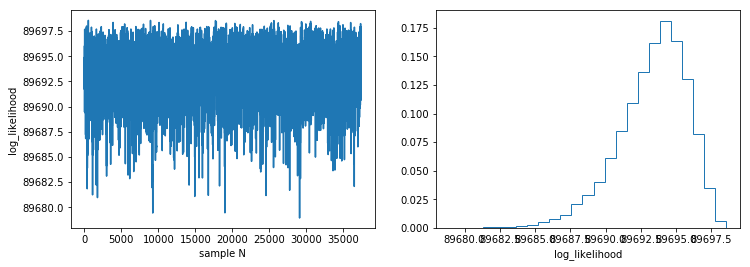

In [102]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.plot(chain[:,-4])
ax1.set_ylabel('log_likelihood')
ax1.set_xlabel('sample N')

ax2 = fig.add_subplot(122)
ax2.hist(chain[:,-4], bins=25, normed=True, histtype='step')
ax2.set_xlabel('log_likelihood')


### white noise

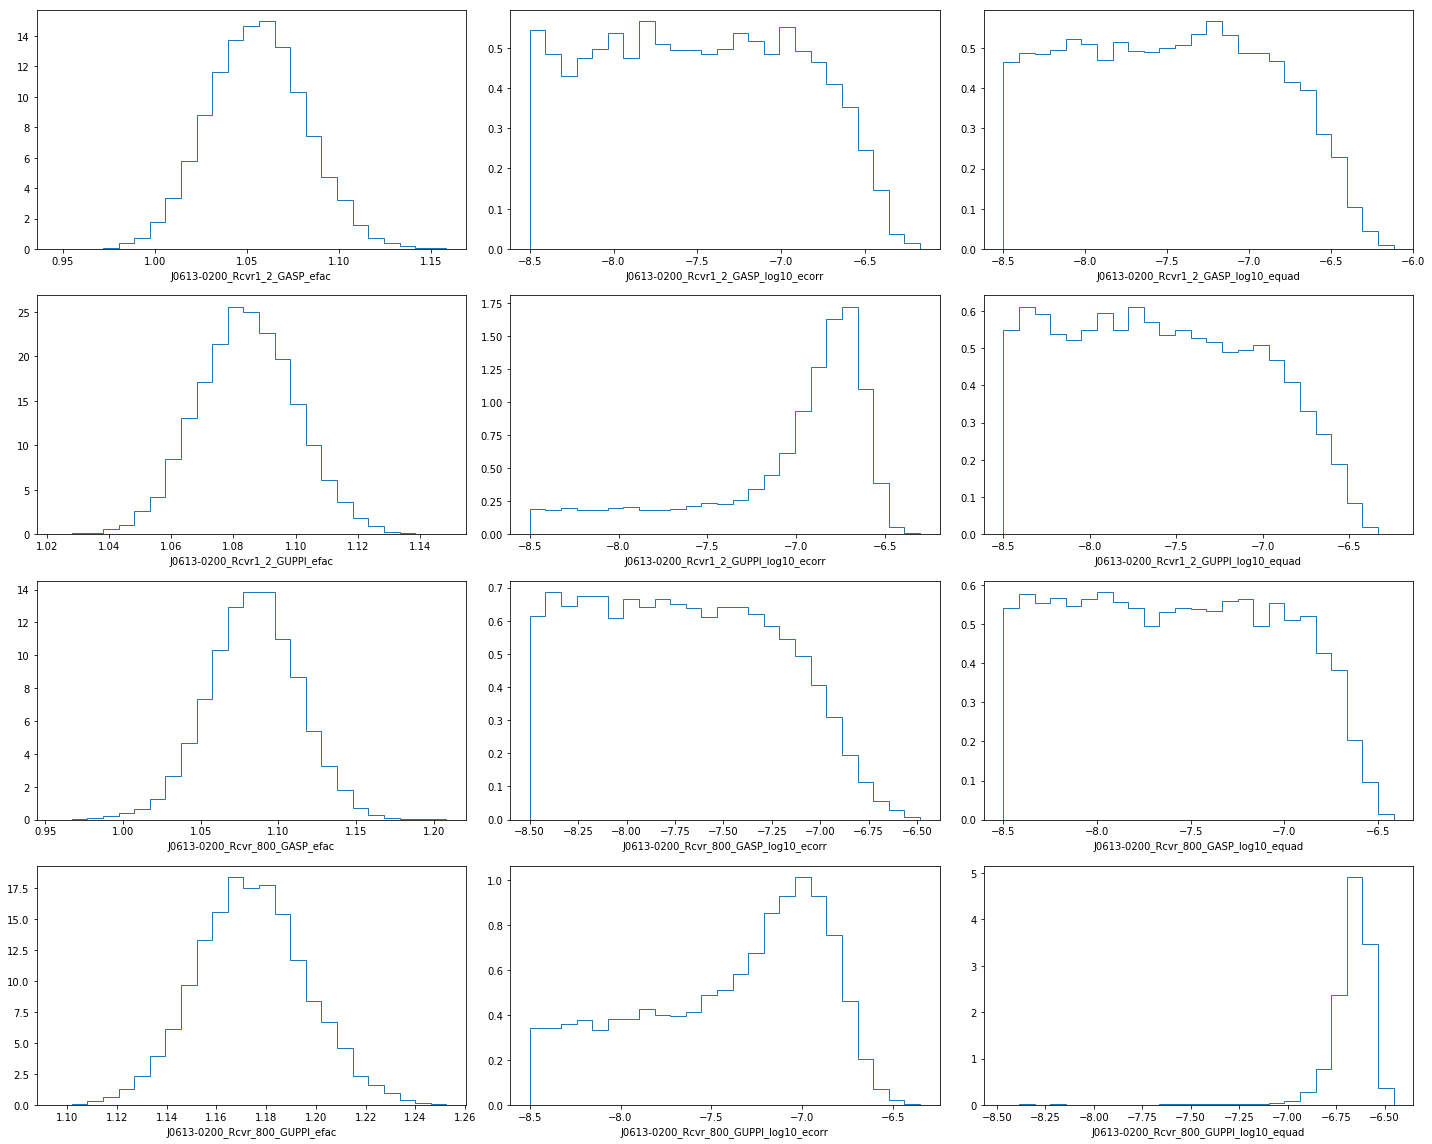

In [103]:
Ncols = 3
Nrows = len(par_WN)//Ncols
if Nrows*Ncols < len(par_WN):
    Nrows += 1
ax = []
fig = plt.figure(figsize=(20,16))

for pp, par in enumerate(par_WN):
    ax.append(fig.add_subplot(Nrows, Ncols, pp+1))
    ax[pp].hist(chain[:,pp], bins=25, normed=True, histtype='step') #, label='')
    ax[pp].set_xlabel(par)
plt.tight_layout()

### red noise spectral params

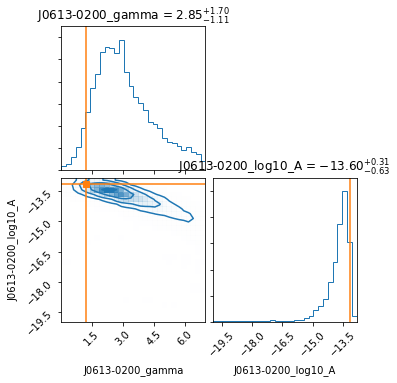

In [113]:
# timing paper params
log10_A = timing_RN[PSR+'_log10_A']
gamma = timing_RN[PSR+'_gamma']

corner_kwargs = {'bins':30,
                 'labels':par_RN,
                 'show_titles':True,
                 'truths':[gamma, log10_A],
                 'truth_color':'C1',
                 'smooth':0.75,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(chain[:,idx_RN], color='C0', **corner_kwargs);

### t-process params

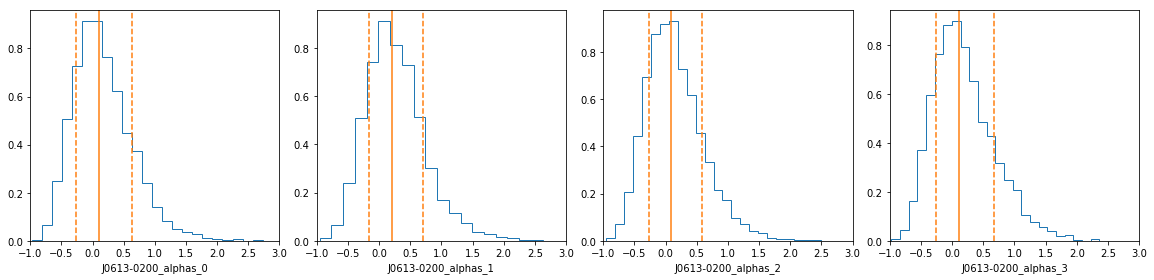

In [105]:
if snglT:
    TPplot = chain[:,idx_TP]
    TPplot[:,0] = np.log10(TPplot[:,0])
    fig = plt.figure(figsize=(12,4))
    ax = []
    for pp, par in enumerate(par_TP):
        ax.append(fig.add_subplot(1, 2, pp+1))
        ax[pp].hist(TPplot[:,pp], bins=25, normed=True, histtype='step')
        ax[pp].set_xlabel(par)
    plt.tight_layout()
else:
    logTP = np.log10(chain[:,idx_TP])
    Ncols = 5
    Nrows = len(par_TP)//Ncols
    if Nrows*Ncols < len(par_TP):
        Nrows += 1
    ax = []
    fig = plt.figure(figsize=(20,4*Nrows))
    for pp, par in enumerate(par_TP):
        ax.append(fig.add_subplot(Nrows, Ncols, pp+1))
        ax[pp].hist(logTP[:,pp], bins=25, normed=True, histtype='step')
        
        med, lower, upper = np.percentile(logTP[:,pp], [50, 18, 84])
        ax[pp].axvline(x=med, color='C1')
        ax[pp].axvline(x=lower, color='C1', linestyle='--')
        ax[pp].axvline(x=upper, color='C1', linestyle='--')
        ax[pp].set_xlabel(par)
        ax[pp].set_xlim([-1,3])
    plt.tight_layout()

In [90]:
fs = (np.arange(30)+1)/Tspan
for pp, par in enumerate(par_TP):
    med, lower, upper = np.percentile(logTP[:,pp], [50, 18, 84])
    print("alpha_{:d}: f = {:.2f} nHz, med(alpha) = {:.3f}".format(pp, fs[start+pp]*1e9, 10**med))

alpha_0: f = 10.57 nHz, med(alpha) = 1.246
alpha_1: f = 14.09 nHz, med(alpha) = 1.569
alpha_2: f = 17.61 nHz, med(alpha) = 1.041
alpha_3: f = 21.13 nHz, med(alpha) = 1.029


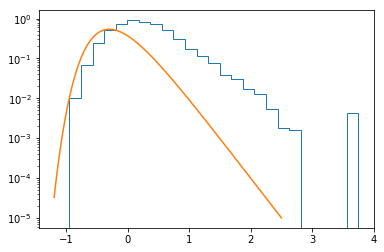

In [106]:
import scipy.stats as sst
prior_rv = sst.invgamma(1, scale=1)

xs = np.logspace(-1.2, 2.5, 200)
P = prior_rv.pdf(xs)

plt.hist(logTP[:,1], bins=25, normed=True, histtype='step')
plt.plot(np.log10(xs), P)
plt.yscale('log')

### t-process noise spectrum

In [107]:
Tspan = 360431065.460732  # from sampler notebook! use full PTA tspan for all
Tspan = 283916804.981542  # 9yr
fs = (np.arange(30)+1)/Tspan

In [108]:
# get samples from chain
M = 250
samp_rho = []
for ii in range(M):
    kk = np.random.randint(N)
    
    gamma, log10_A = chain[kk, idx_RN].T
    #log10_A = chain[kk, idx_RN[1]]
    if snglT:
        alphas = np.ones_like(fs)
        try:
            alpha, idx = chain[kk, idx_TP]
            idx = int(np.rint(idx))
        except:
            alpha = chain[kk, idx_TP]
            idx = 5
        alphas[idx] = alpha
    elif truncT:
        alphas = np.ones_like(fs)
        als = chain[kk, idx_TP]
        alphas[start:len(als)+start] = als
    else:
        alphas = chain[kk, idx_TP]

    rho_pl = 10**log10_A / (np.sqrt(12)*np.pi) * const.fyr**((gamma-3)/2) * fs**(-gamma/2) / np.sqrt(Tspan)
    rho = rho_pl * alphas
    
    samp_rho.append(rho)


# MAP
#kk = np.argmax(chain[:,-4])
#gamma, log10_A = chain[kk, idx_RN]
#if snglT:
#    alphas = np.ones_like(fs)
#     try:
#        alpha, idx = chain[kk, idx_TP]
#        idx = int(np.rint(idx))
#    except:
#        alpha = chain[kk, idx_TP]
#        idx = 5
#    alphas[idx] = alpha
#    elif truncT:
#        alphas = np.ones_like(fs)
#        als = chain[kk, idx_TP]
#        alphas[start:len(als)+start] = als
#else:
#    alphas = chain[kk, idx_TP]

# median everything...
gamma, log10_A = np.array([np.percentile(chain[:, ii], 50) for ii in idx_RN])
#alphas = np.array([np.percentile(chain[:, ii], 50) for ii in idx_TP])
alphas = np.ones_like(fs)
if snglT:
    alpha = np.percentile(chain[:, idx_TP], 50)
    alphas[idx] = alpha
elif truncT:
    als = np.array([np.percentile(chain[:, ii], 50) for ii in idx_TP])
    alphas[start:len(als)+start] = als

rho_pl = 10**log10_A / (np.sqrt(12)*np.pi) * const.fyr**((gamma-3)/2) * fs**(-gamma/2) / np.sqrt(Tspan)
rho = rho_pl * alphas

In [109]:
# timing paper params
log10_A = timing_RN[PSR+'_log10_A']
gamma = timing_RN[PSR+'_gamma']

timing_rho = 10**log10_A / (np.sqrt(12)*np.pi) * const.fyr**((gamma-3)/2) * fs**(-gamma/2) / np.sqrt(Tspan)

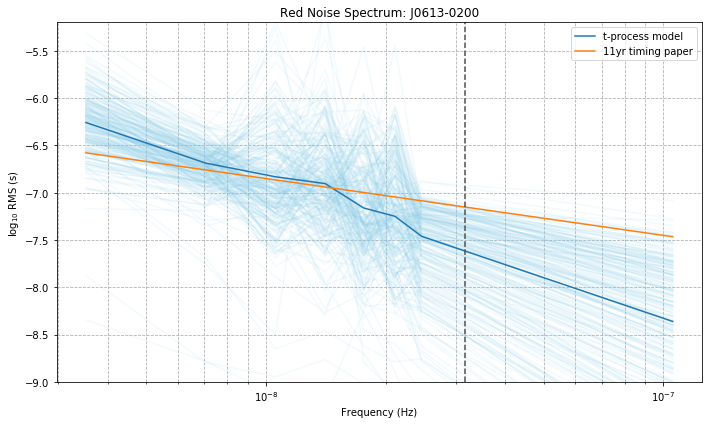

In [110]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

for r in samp_rho:
    ax.plot(fs, np.log10(r), color='skyblue', alpha=0.1)
ax.plot(fs, np.log10(rho), color='C0', ls='-', label="t-process model")
ax.plot(fs, np.log10(timing_rho), color='C1', ls='-', label="11yr timing paper")
#ax.plot(fs, np.log10(rho_11yr), color='C2', ls='-', label="11yr RN")
ax.axvline(1./const.yr, color='0.3', ls='--')

ax.set_title('Red Noise Spectrum: ' + PSR)
ax.set_ylabel('$\log_{10}$ RMS (s)')
ax.set_xlabel('Frequency (Hz)')
ax.grid(which='both', ls='--')
ax.set_xscale('log')
ax.set_ylim([-9.0, -5.2])
ax.legend()

plt.tight_layout()

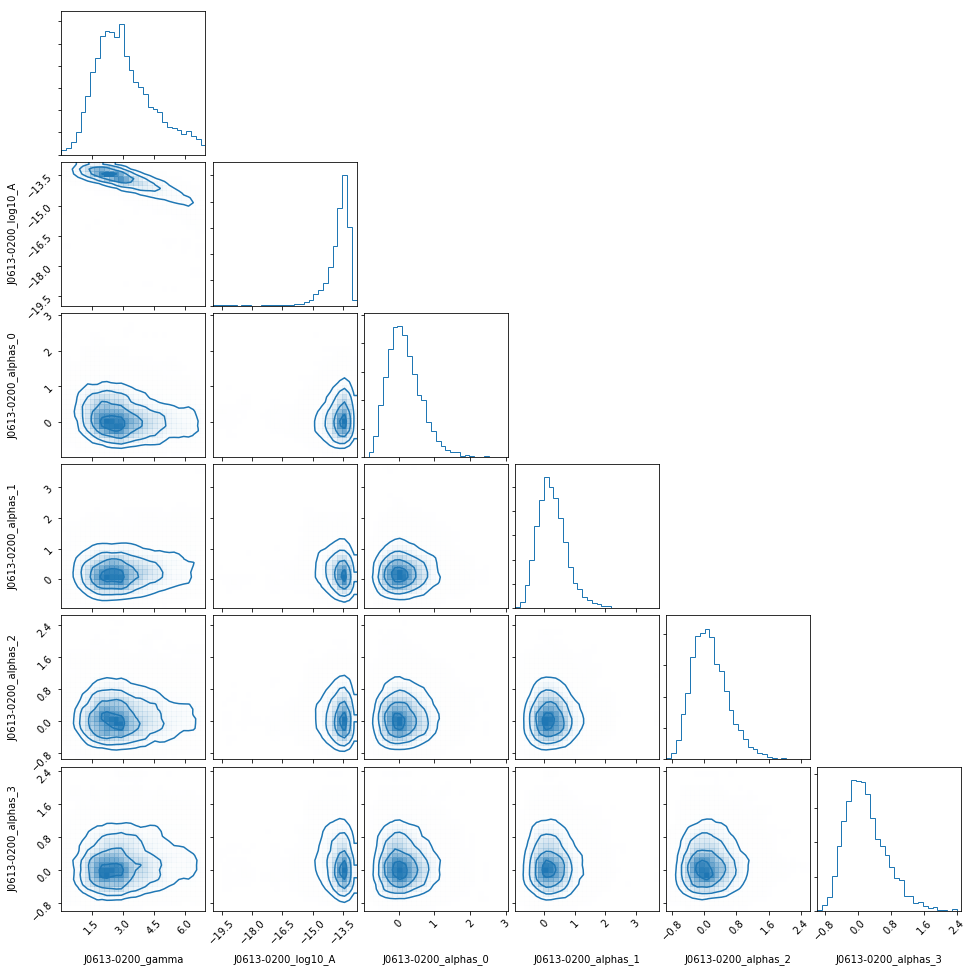

In [114]:
# timing paper params
log10_A = timing_RN[PSR+'_log10_A']
gamma = timing_RN[PSR+'_gamma']

plot_chain = np.hstack( [chain[:,idx_RN], np.log10(chain[:,idx_TP])] )
plot_labels = par_RN + par_TP

corner_kwargs = {'bins':30,
                 'labels':plot_labels,
                 #'truths':[gamma, log10_A] + [0]*len(par_TP),
                 #'truth_color':'C1',
                 'smooth':0.75,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,}

fig = corner(plot_chain, color='C0', **corner_kwargs);

# Noise from 11yr time-slice

In [614]:
rundir = '/home/pbaker/nanograv/bwm/slices/11.5/DE436/'

with open(rundir + 'params.txt', 'r') as f:
    params11 = [line.rstrip('\n') for line in f]

idx_RN11 = [params11.index(PSR+'_gamma'), params11.index(PSR+'_log10_A')]

chain_11yr = pd.read_csv(rundir + 'chain_1.txt',
                    sep='\t', dtype=float, header=None).values

burn = int(0.15 * len(chain_11yr))
ch_11 = chain_11yr[burn:-1,:-1]

corrL = acor(ch_11[:,-4])[0]
N = len(ch_11)
print("N = {}, corr(logL) = {}".format(N, corrL))

N = 97749, corr(logL) = 594.29871954


In [615]:
gamma, log10_A = np.array([np.percentile(ch_11[:, ii], 50) for ii in idx_RN11])

rho_11yr = 10**log10_A / (np.sqrt(12)*np.pi) * const.fyr**((gamma-3)/2) * fs**(-gamma/2) / np.sqrt(Tspan)

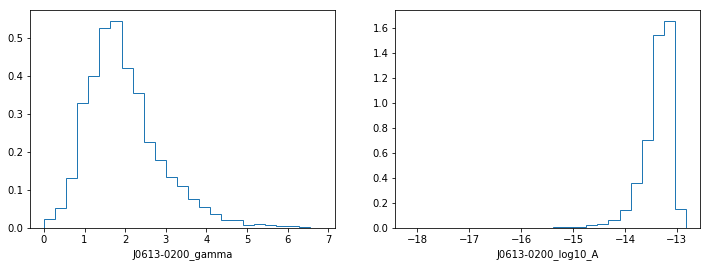

In [616]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(ch_11[:,idx_RN11[0]], bins=25, normed=True, histtype='step')
plt.xlabel(params11[idx_RN11[0]])

plt.subplot(122)
plt.hist(ch_11[:,idx_RN11[1]], bins=25, normed=True, histtype='step')
plt.xlabel(params11[idx_RN11[1]])

In [478]:
gamma, log10_A

(2.5791548789555034, -13.267316363874775)

In [ ]:
rundir = '/home/pbaker/nanograv/gwb/tests/selectedRN/'

with open(rundir + 'params.txt', 'r') as f:
    params11 = [line.rstrip('\n') for line in f]

idx_RN11 = [params11.index(PSR+'_gamma'), params11.index(PSR+'_log10_A')]

chain_11yr = pd.read_csv(rundir + 'chain_1.txt',
                    sep='\t', dtype=float, header=None).values

burn = int(0.15 * len(chain_11yr))
ch_11 = chain_11yr[burn:-1,:-1]

corrL = acor(ch_11[:,-4])[0]
N = len(ch_11)
print("N = {}, corr(logL) = {}".format(N, corrL))